# Blackjack Monte Carlo

This notebook works thru the problem of first visit MC prediction for estimating V ≈ v<sub>π.
    
We apply a highly naive policy of sticking at 19 for the player and 17 for the dealer.
    
Rewards of +1, -1, and 0 are given for winning, losing, and drawing, respectively. 

    
First we simulate games with the simple policies and basic rules of blackjack then we approximate V.
    
Objects to create:
- environment to simulate the blackjack game rules
- entity objects to sumulate players and the dealer
- value estimation object

In [1]:
import itertools
import numpy as np
import seaborn as sns
import pandas as pd


In [2]:
#build environment
class blackjack_class():
    def __init__(self):
        self.cards_in_play = {"player":[],"dealer":[]}
                
        self.suits = ['h','d','s','c']
        self.values = [['a', 11]] + [[str(i), i] for i in range(2,11)] + [['j', 10],['q', 10],['k', 10]]
        
        self.deck = []
        for i in self.suits:
            for j in self.values:
                self.deck.append([i, j[0], j[1]])
                
        #print(self.deck)

    def check_hand(self, entity, flag = None):
        """
        checks if hand is bust or open
        """
        #print(entity, self.cards_in_play[entity])
        total = sum([i[2] for i in self.cards_in_play[entity]])
       
        if total > 21:

            if flag != "post":
                if self.flip_ace(entity):
                    bust, total = self.check_hand(entity)
                else:
                    bust = True
            else:
                bust = True
        else:
            bust = False

        return bust, total

    def deal_hand(self, player, dealer):
        
        self.cards_in_play = {"player":[],"dealer":[]}
        #align the cards for the deal
        player.new_hand()
        dealer.new_hand()
        
        self.deal = np.random.choice([i for i in range(52)], size=52, replace=False)
        
        self.cards_in_play["player"].append(self.deck[self.deal[0]].copy())
        self.cards_in_play["player"].append(self.deck[self.deal[2]].copy())
        self.cards_in_play["dealer"].append(self.deck[self.deal[1]].copy())
        self.cards_in_play["dealer"].append(self.deck[self.deal[3]].copy())
        
        self.card_count = 4
        
        check, total = self.check_hand("player")
        
        self.dealer_show = self.deck[self.deal[3]]
        
    def deal_hit(self, entity):
        self.cards_in_play[entity].append(self.deck[self.deal[self.card_count]].copy())
        self.card_count = self.card_count + 1
        check, total = self.check_hand(entity)
        
        return self.cards_in_play["player"], total, self.dealer_show, check
    
    def flip_ace(self, entity):
        cards = self.cards_in_play[entity]
        #need logic to detect ace and check if it is already 1 to exit or you end up with infinite loop
        #return ace_check flag

        for i in range(len(cards)):
            ace_flip = False
            cards[i]
            if cards[i][1] == 'a':
                if cards[i][2] == 11:
                    cards[i][2] = 1
                    ace_flip = True
                    
        
        self.cards_in_play[entity] = cards
        
        return ace_flip

    def give_data(self):
        
        dealer_bust, dealer_total = self.check_hand("dealer", "post")
        player_bust, player_total = self.check_hand("player", "post")
        
        return [self.cards_in_play["player"], self.dealer_show, dealer_bust, dealer_total, player_bust, player_total]
    

In [3]:
#entity object
class entity_class():
    """
    simple object to follow typical house rules, hit on 16 stay on 17
    """
    def __init__(self, entity = None, stick = None):
        self.entity = entity
        self.stick = stick
        
        self.total = 0        
        self.cards = []
        
    def new_hand(self):
        self.total = 0
        self.cards = []
        
    def check_total(self, environment):
        """
        checks dealers total
        """
        bust, self.total = environment.check_hand(self.entity)
        
        if self.total < self.stick:
            self.take_hit(environment)
        
    def take_hit(self, environment):
        bust, self.total, dealer_show, check = environment.deal_hit(self.entity)
        if self.total < self.stick:
            self.take_hit(environment)
            

In [4]:
house= blackjack_class()
player = entity_class("player", 19)
dealer = entity_class("dealer", 17)


In [5]:
house.deal_hand(player, dealer)

player.check_total(house)

dealer.check_total(house)

response_list = house.give_data()

print(response_list)


[[['c', '4', 4], ['h', '3', 3], ['s', '2', 2], ['s', '10', 10]], ['s', '4', 4], False, 20, False, 19]


In [6]:
#run sim and acquire data
def run_sim(num_episodes = 500000):
    house= blackjack_class()
    player = entity_class("player", 19)
    dealer = entity_class("dealer", 17)
    tracking_data = []
    
    for i in range(num_episodes):

        house.deal_hand(player, dealer)
        
        player.check_total(house)

        dealer.check_total(house)

        response_list = house.give_data()
        
        tracking_data.append(response_list)
        
    return tracking_data
  

In [7]:
output = run_sim()


In [8]:
# organize output to something usable
tracker = []

# state will be total for player, dealer card showing, , playable ace, value (win, draw, lose)
for i in range(len(output)):
    
    #check players hand (this enables us to effectively put in place another policy which is that if we have less than 12 on hand we obviously hit)
    j = 0
    player_hand = 0
    playable_ace = 0
    
    while player_hand < 12:
    
        if output[i][0][j][1] == 'a':
            playable_ace = 1
            player_hand = 11 + player_hand
            if playable_ace and player_hand == 22:
                player_hand = 12
        else:
            player_hand = player_hand + output[i][0][j][2]
        
        
        j = j + 1
        starting_action = j
    
    #get dealers show card
    show_card = output[i][1][1]
    
    value = 0
    
    #check winner
    #output[i][2] dealer bust
    #output[i][3] dealer total
    #output[i][4] player bust
    #output[i][5] player total
    
    #player wins
    if (output[i][4] == False and output[i][5] > output[i][3]) or (output[i][4] == False and output[i][2] == True):
        value = 1
    #tie
    elif output[i][4] == False and output[i][3] == output[i][5]:
        value = 0
    #house wins (always)
    elif output[i][4] == True or (output[i][2] == False and output[i][5] < output[i][3] and output[i][4] == False):
        value = -1
    else:
        print("print value error check")
        print(output[i])
        
    #[ game, playable ace, player total, dealer showing, value]
    tracker.append([i,playable_ace,player_hand,starting_action,show_card, value])     


In [9]:
import pandas as pd

tracker_df = pd.DataFrame(data = tracker, columns = [ "game", "playable_ace", "player_total", "starting_action","dealer_showing", "value"])

tracker_df


,game,playable_ace,player_total,starting_action,dealer_showing,value
0,0,0,17,2,3,-1
1,1,0,12,2,5,-1
2,2,0,16,2,k,-1
3,3,0,13,2,5,1
4,4,0,17,2,5,-1
...,...,...,...,...,...,...
499995,499995,0,12,2,9,-1
499996,499996,0,20,2,q,1
499997,499997,0,13,2,8,-1
499998,499998,0,15,2,10,1


 <br>   
 <strong>From Reinforcement Learning; An Introduction by Sutton and Barto:</strong><br>

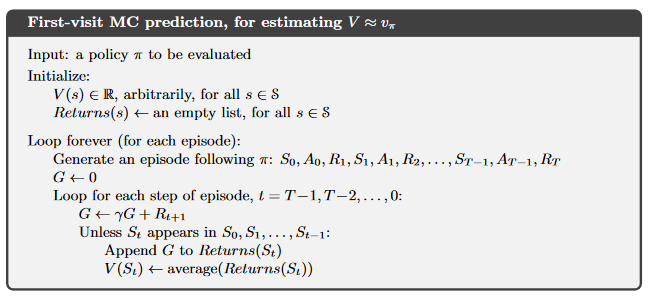


In [10]:
# create estimations
state_values = []
states = []
returns = []
gamma = 1.0 # discount factor

for i in range(len(tracker)):
    #print(i)
    episode_tracking = []
    prior_visited_states = []
        
    player_total = 0
    
    #get player starting hand total
    for k in range(tracker[i][3]):
        player_total = player_total + output[i][0][k][2]
        
        if player_total > 21 and tracker[i][1]:
            player_total = player_total - 10
            
    #state = ["playable_ace", "dealer_showing", "player_total", "G"]
    episode = [tracker[i][1],tracker[i][4],player_total, tracker[i][5]]

    episode_tracking.append(episode)
            
    #print(len(output[i][0]) - 1 - tracker[i][3])
    for j in range(len(output[i][0]) - tracker[i][3]):
        l = j + tracker[i][3]
        #print(j)
        #print(l)
        player_total = player_total + output[i][0][l][2]
        
        if player_total > 21 and tracker[i][1]:
            player_total = player_total - 10
        
        #get player total
              
      
        
        #state = ["playable_ace", "dealer_showing", "player_total", "G"]
        episode = [tracker[i][1],tracker[i][4],player_total, tracker[i][5]]
        
        episode_tracking.append(episode)
    
    #backpropgate to get state values in chain
    #reverse episodes    
    episode_tracking = episode_tracking[::-1]
    
    # set starting g
    G = 0
    
    #loop thru states
    for i in range(len(episode_tracking)):
        
        #extract state and state value (G)
        state = episode_tracking[i][0:3]
        
        #should be if reqards occurred at every state
        if i == 0:
            
            G = (G * gamma) + episode_tracking[i][-1]
        
        #since rewards is at the end it becomes
        else:
            
            G = (G * gamma)
    
        # if previosuly visited state during current episode 
        # this is for first visit
        if state not in prior_visited_states:
            
            prior_visited_states.append(state)

            #update state values
            
            #get index
            try:
                index = states.index(state)
                returns[index].append(G)
                temp = np.mean(returns[index])
                #print(returns[index], np.mean(returns[index]))
                state_values[index] = temp
            except:
                states.append(state)
                returns.append([G])
                state_values.append(G)

final_dump = []
columns = ["usable_ace","dealer_show","player_total","value"]
for i in range(len(states)):
    final_dump.append([states[i][0], states[i][1], states[i][2], state_values[i]])
    
pdf_output = pd.DataFrame(data = final_dump, columns = columns)

pdf_output = pdf_output[pdf_output["player_total"] < 22]
pdf_output = pdf_output[pdf_output["player_total"] > 11]

pdf_output_good_states = pdf_output

In [11]:
print(len(states))

481


In [12]:
print(len(state_values))

481


In [13]:
print(len(returns))

481


In [14]:
pdf_output_good_states

,usable_ace,dealer_show,player_total,value
1,0,3,17,-0.607430
3,0,5,12,-0.401306
5,0,k,16,-0.610055
6,0,5,19,0.481117
7,0,5,13,-0.424393
...,...,...,...,...
443,1,a,13,-0.534118
444,1,j,15,-0.224806
446,1,j,17,-0.230000
447,1,k,16,-0.266304


In [15]:
pdf_output_good_states_ace = pdf_output_good_states[pdf_output_good_states["usable_ace"] == 1]
pdf_output_good_states_non = pdf_output_good_states[pdf_output_good_states["usable_ace"] == 0]

# display state values 


In [16]:
def plot_heat(df):
    
    df = df.pivot(index='player_total', columns='dealer_show', values='value')

    sns.heatmap(df)


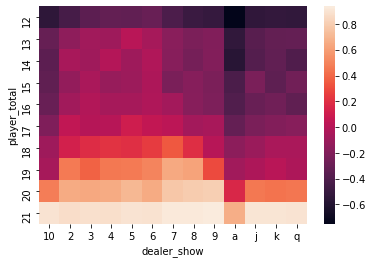

In [17]:
plot_heat(pdf_output_good_states_ace)

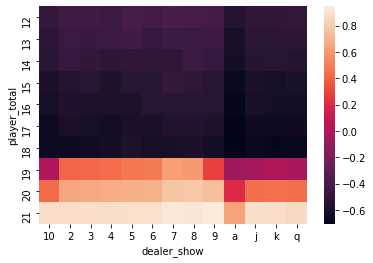

In [18]:
plot_heat(pdf_output_good_states_non)